In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import numpy as np
import math
import warnings
from IPython.display import display, HTML

%matplotlib inline  
sns.set(font_scale=1.3)

# Diamond Pricing
This notebook investigates the pricing of diamonds. The source of the dataset is https://www.kaggle.com/shivam2503/diamonds. There are 53940 rows and 10 variables. There is one line per diamond. We do principle component analysis to figure out which factors are most important. Use of machine learning to price new diamonds is demonstrated.  Fields in the dataset include:

* _price_ -  price in US dollars (\$326--\$18,823)
* _carat_ weight of the diamond (0.2--5.01)
* _cut_ quality of the cut (Fair, Good, Very Good, Premium, Ideal)
* _color_ diamond colour, from J (worst) to D (best)
* _clarity_ a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
* _x_ length in mm (0--10.74)
* _y_ width in mm (0--58.9)
* _z_ depth in mm (0--31.8)
* _depth_ total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
* _table_ width of top of diamond relative to widest point (43--95)

## Summary of contents

* [Loading of the data and initial exploration](#init) - The training set is loaded and sample data is displayed.  We see that the dimensional variables are all proxies and that analysis based on carat is sufficient. We cluster the data manually based on known consumer groups and patterns in the carat vs price data set. This extracted feature appears to be particularly useful for larger diamonds. We also consider price and carat relationships for diamond groups (e.g. Fair, D and VVS2). We find that the square root of price is typically linear with respect to carat, up to about 1.75 carats or so.
* [Price prediction](#predict) Based on the analysis in the first part, predictive models for price are built with regression trees and linear regression. Their performance is compared and an ensemble is built.

## Loading of the data and initial exploration <a class="anchor" id="init"></a>

In [2]:
# Load training data into a data frame. 
input_filename = "diamonds.csv"
df = pd.read_csv(input_filename, index_col=0) 

#Output some sample data
display(df.head())

#Output some summary info
display(df.describe())

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


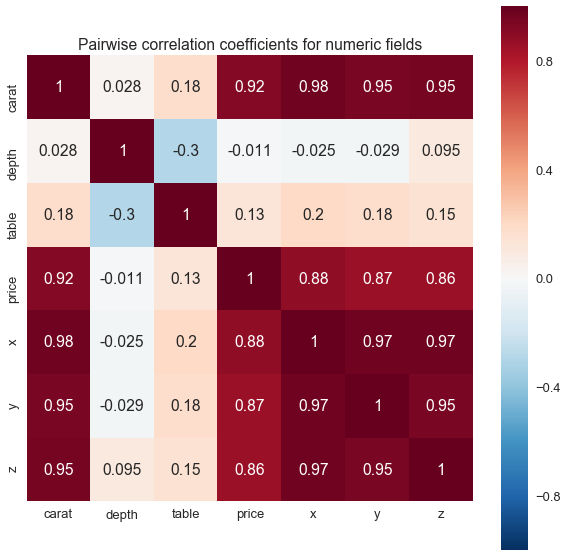

In [3]:
#Display pairwise correlations
fig, ax = plt.subplots(figsize=(10,10)) 
g = sns.heatmap(df.corr(), square=True, annot = True);
g.set_title('Pairwise correlation coefficients for numeric fields');

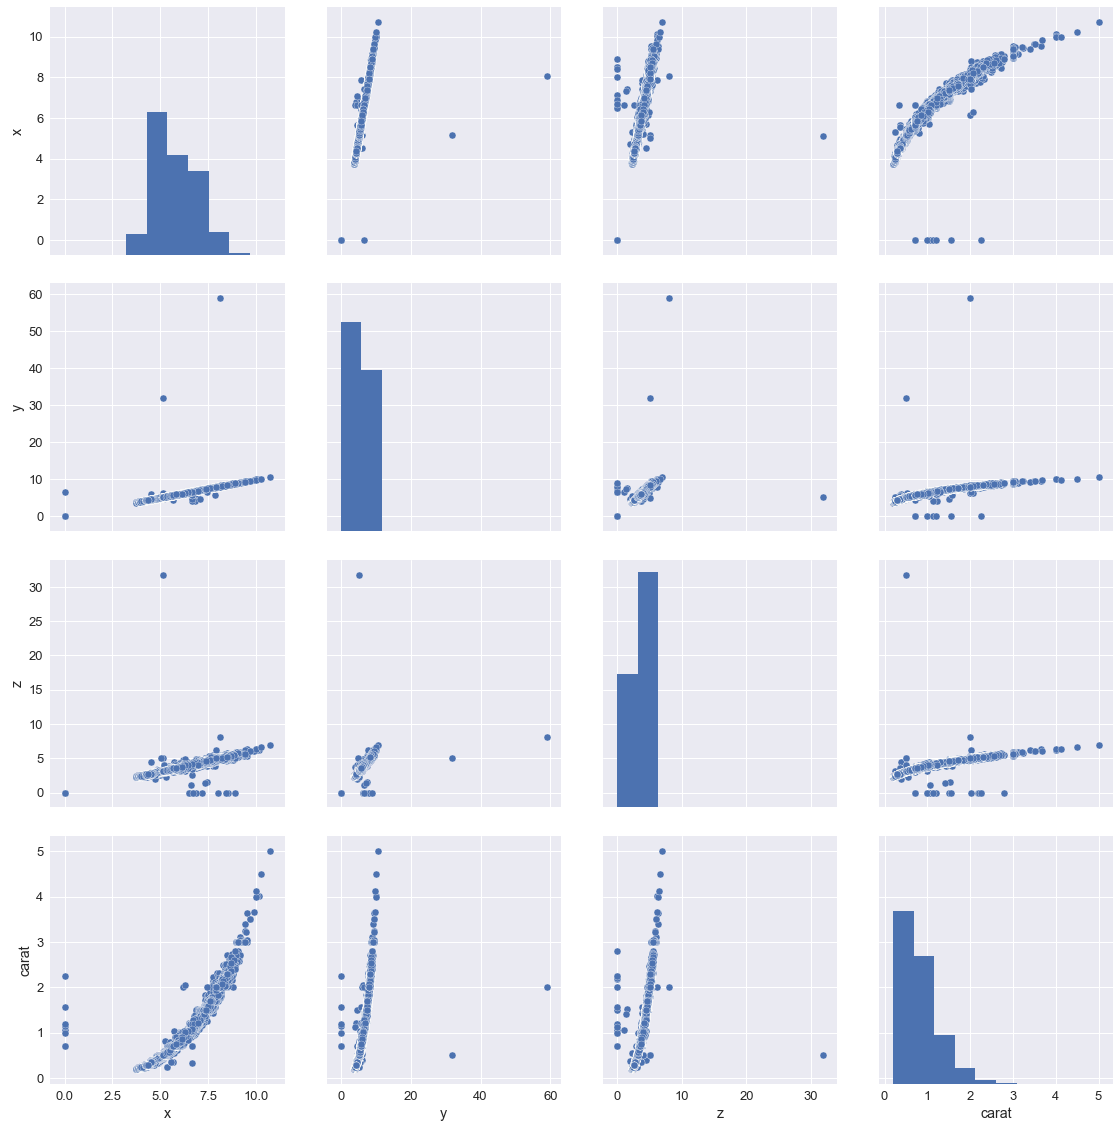

In [4]:
# Do a pairwise plot of the corellated dimensional variables
g = sns.pairplot(df, vars=['x','y','z','carat'], size=4);

We can see that price is strongly correllated with the dimensions of the diamonds, and most of the dimensions are strongly corellated too. All of those quantities are strongly correlated with the carat, which is a measure of mass (and therefore by proxy, volume). It looks like carat is a cubic function of x, y and z, as you'd expect. Since they're usually related, let's just have a look at carat vs price first.

### Price vs Carat segmentation

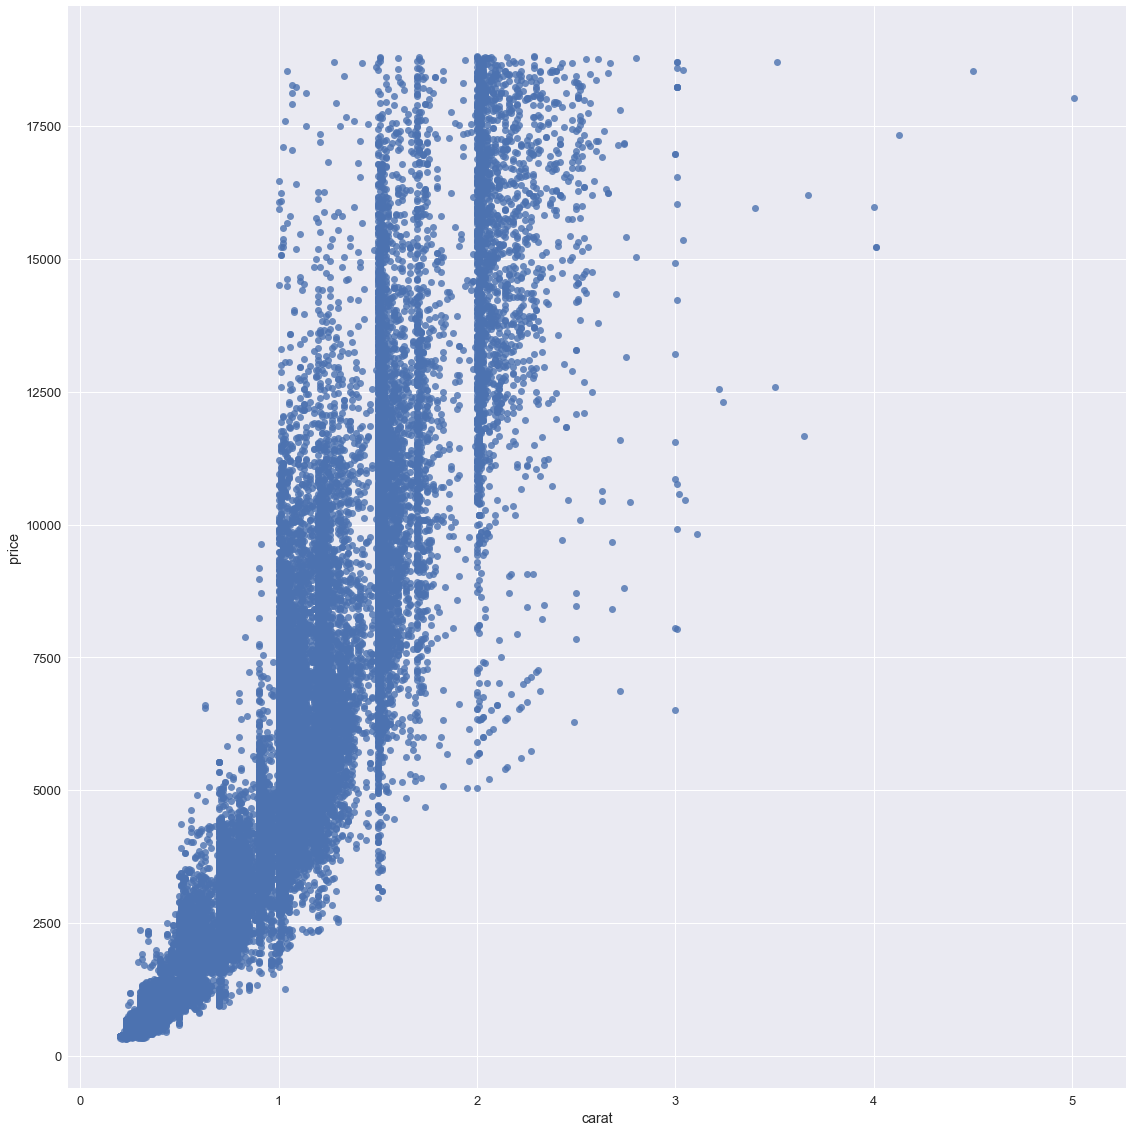

In [5]:
g = sns.lmplot('carat', 'price', data=df, fit_reg=False, scatter=True, size=16);

My partner, whose parents are in the jewellery business, mentioned that prices jump up at certain price points essentially because of cosumer minimum size expectations for wedding rings. E.g. they expect 1 caret, or 1.5 carets, or whatever. For that reason we'll cluser the rings into groups divided by the price points visible in the data set. It doesn't seem like any of the built in clustering algorithms will do a good job of this without alot of fiddling, and there are clear market reasons for the groupings, so we'll just do it by hand.

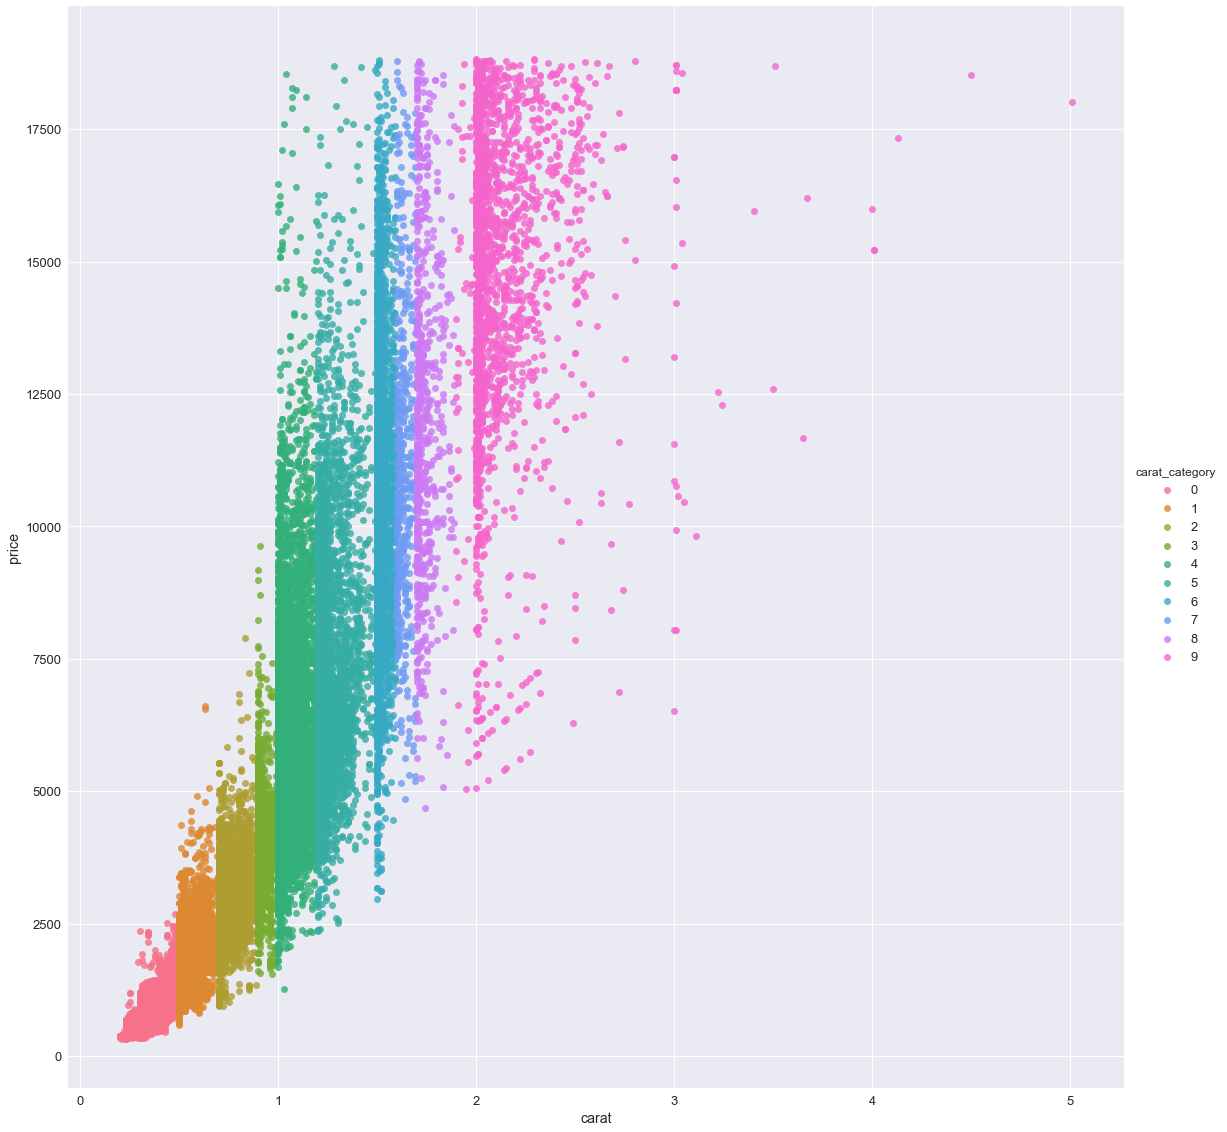

In [6]:
def caratCategorizer(carat):
    #Puts diamonds into categories depending on the caret.
    if carat < 0.5:
        return 0
    elif 0.5 <= carat < 0.7:
        return 1 
    elif 0.7 <= carat < 0.9:
        return 2 
    elif 0.9 <= carat < 1:
        return 3 
    elif 1 <= carat < 1.2:
        return 4 
    elif 1.2 <= carat < 1.5:
        return 5  
    elif 1.5 <= carat < 1.6:
        return 6 
    elif 1.6 <= carat < 1.7:
        return 7
    elif 1.7 <= carat < 1.9:
        return 8
    elif 1.9 <= carat:
        return 9
#Add the category column
df['carat_category'] = list(map(caratCategorizer ,df['carat']))

#Plot the price vs carat again, with category for hue.
g = sns.lmplot('carat', 'price', hue='carat_category', data=df, fit_reg=False, scatter=True, size=16);

###  Diamond groups - clarity, cut and color 

Let's see what happens when we look at some random clarity, cut and color diamond groups.

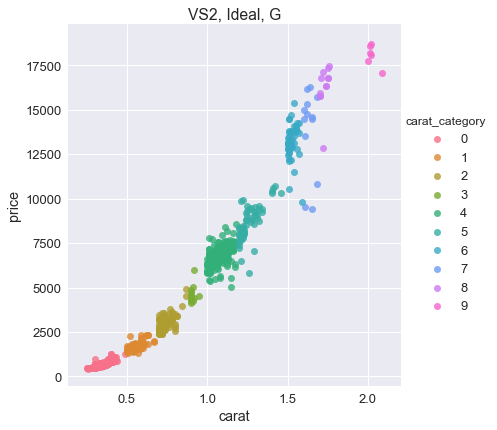

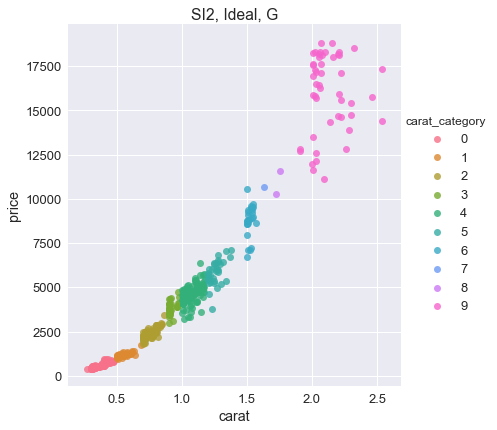

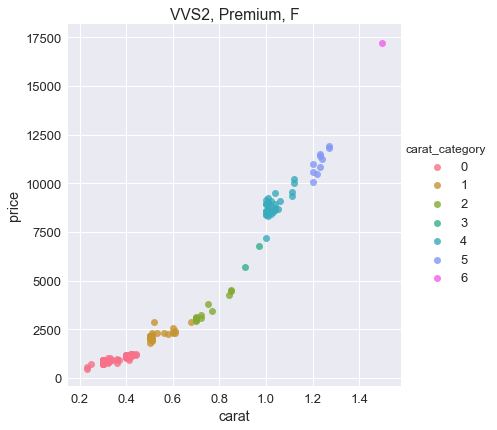

In [14]:
def plt_category(sample, title, ylabel='price', reg=False):
    #Plot caret vs price
    if reg:
        #Don't put hue on the carat_category since we'd end up with a regression line for every category
        g = sns.lmplot('carat', 'price', data=sample, fit_reg=reg, scatter=True, size=6);
    else:
        g = sns.lmplot('carat', 'price', hue='carat_category', data=sample, fit_reg=reg, scatter=True, size=6);
    ax = g.axes.flatten()[0];
    ax.set_title(title);
    ax.set_ylabel(ylabel);

def plt_random_category(price_fn_map=(lambda x : x),reg=False, ylabel='price', min_samples=100):
    #Plot carat vs price in a random diamond category. Reroll if there aren't many points. 
    #pricefnmap applies a function to the price, so we can figure out what sort it is later on.
    #if there are not greater than min_samples we'll try another sample.
    rnd_clarity = np.random.choice(df['clarity'].unique())
    rnd_cut = np.random.choice(df['cut'].unique())
    rnd_color = np.random.choice(df['color'].unique())
    sample = df[(df['clarity']==rnd_clarity) & (df['cut']==rnd_cut) & (df['color']==rnd_color)]
    sample = sample.reindex()
    sample['price'] = list(map(price_fn_map,sample['price']))
    title = rnd_clarity+", "+rnd_cut+", "+rnd_color
    if len(sample) > min_samples:
        plt_category(sample, title,ylabel,reg)
    else:
        plt_random_category(price_fn_map,reg,ylabel,min_samples)

#Randomly choose some larger clarity cut and color diamond groups and plot them
for i in range(3):
    plt_random_category()

The segmentation is really noticable. One might ask what sort of function the price is of carat. The type of relationship looks the same between categories. Let's pick the SL2, Very good and H category and graph the logarithm vs price. If the relationship is exponential, then we should be left with a straight line. If it's polynomial, we should get something that looks like a logarithm function.

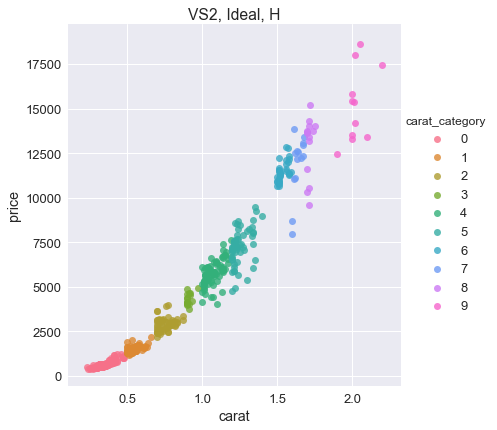

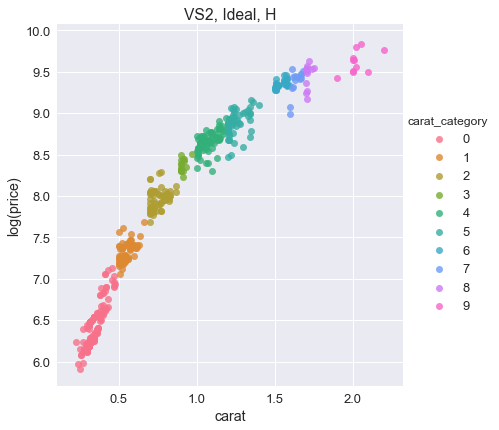

In [8]:
#Randomly choose a clarity cut and color diamond groups and plot them, taking the logarithm of the price.

clarity = 'VS2'
cut = 'Ideal'
color = 'H'
sample = df[(df['clarity']==clarity) & (df['cut']==cut) & (df['color']==color)]
sample = sample.reindex()


title = clarity+", "+cut+", "+color

#Plot the thing we are looking at before doing anything to it
plt_category(sample, title)

# take the log of price in our sample
sample['price'] = list(map(math.log,sample['price'])) 

ylabel = 'log(price)'
plt_category(sample, title, ylabel)

The graph appears to be logarithmic. Hence, price isn't exponential with respect to caret and we suspect a polynomial function. Let's try taking a few different nth roots instead.

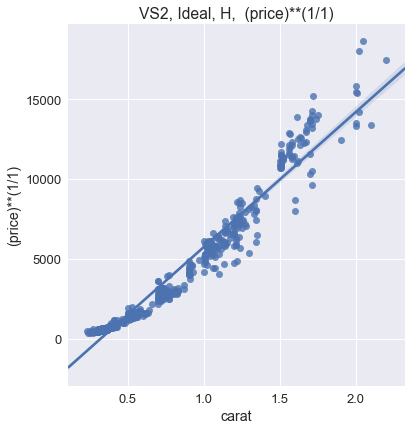

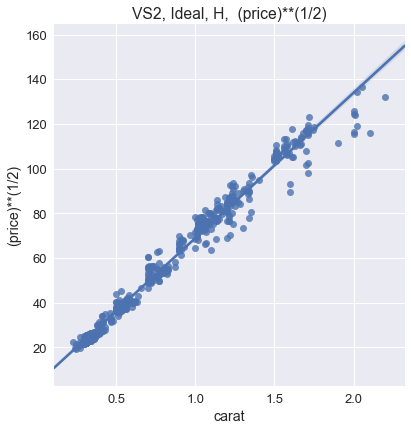

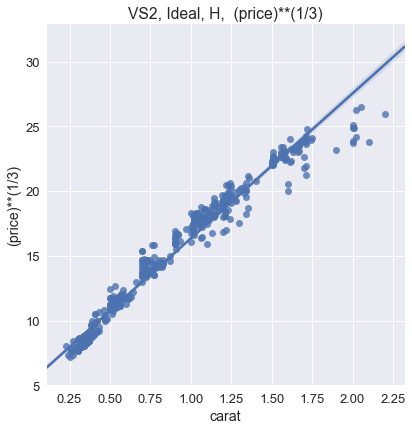

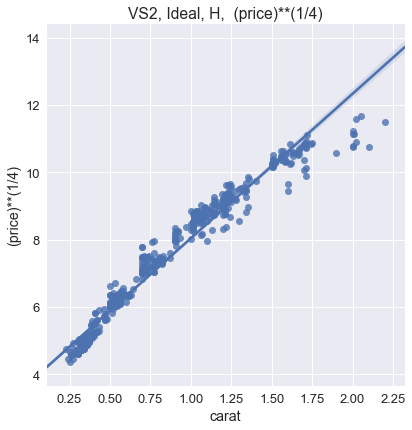

In [9]:
#Randomly choose a clarity cut and color diamond groups and plot them, taking the logarithm of the price.
for p in range(1,5):
    sample = df[(df['clarity']==clarity) & (df['cut']==cut) & (df['color']==color)]
    sample = sample.reindex()
    sample['price'] = list(map(lambda x : x**(1/p),sample['price'])) # take the log of price in our sample

    title = clarity+", "+cut+", "+color+',  (price)**(1/'+str(p)+')'
    ylabel = '(price)**(1/'+str(p)+')'
    plt_category(sample, title, ylabel, True)

It looks like the relationship is probably quadratic up to 1.75 carats or so. Let's check that by plotting the cube root of some random samples.

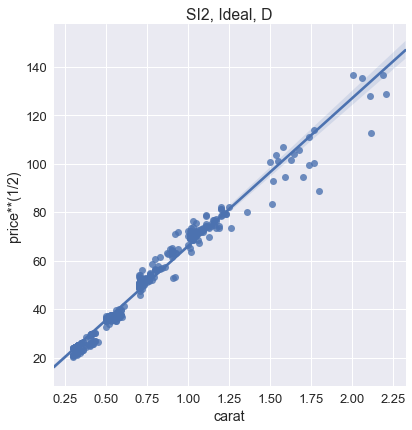

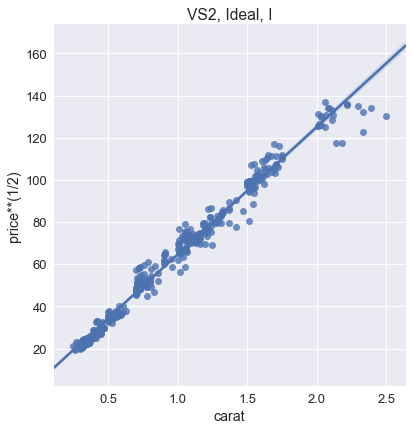

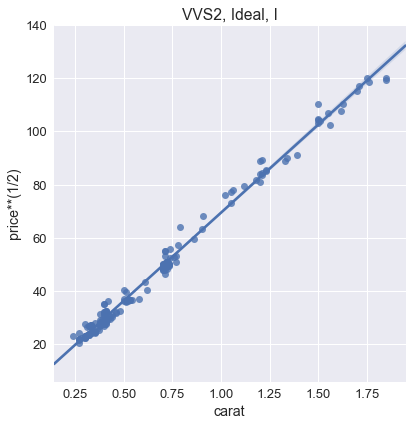

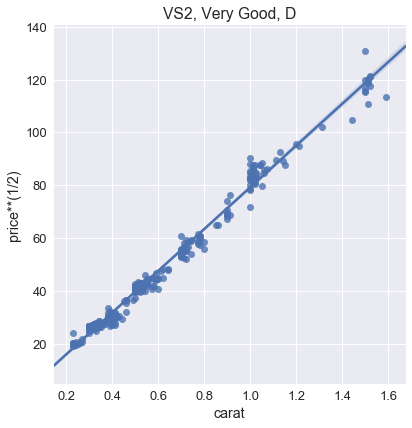

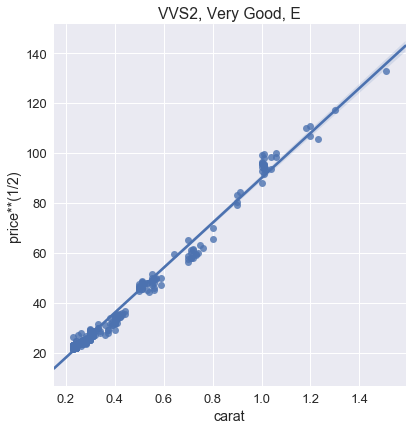

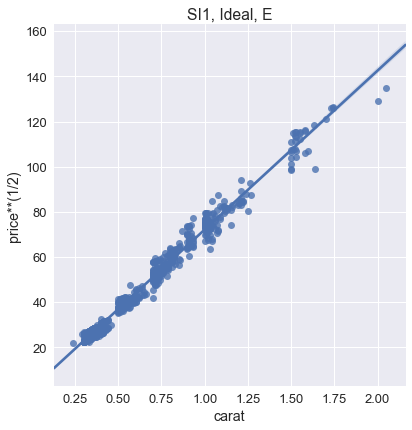

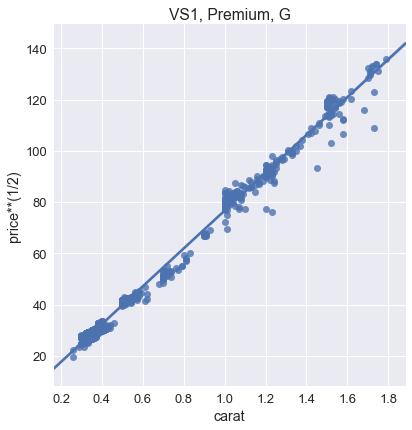

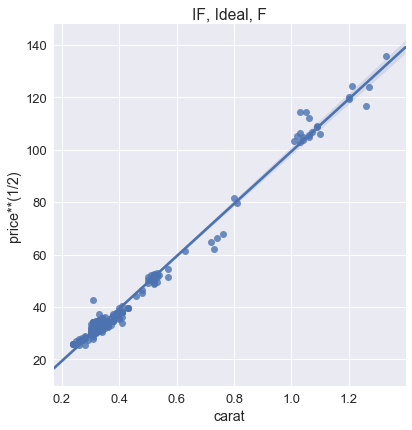

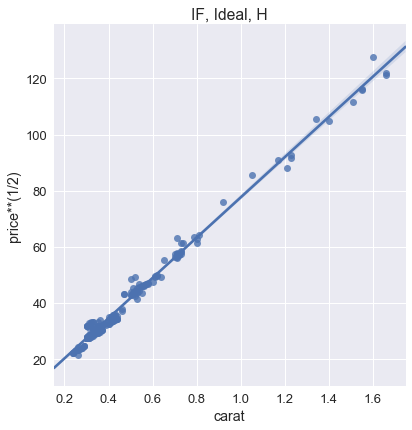

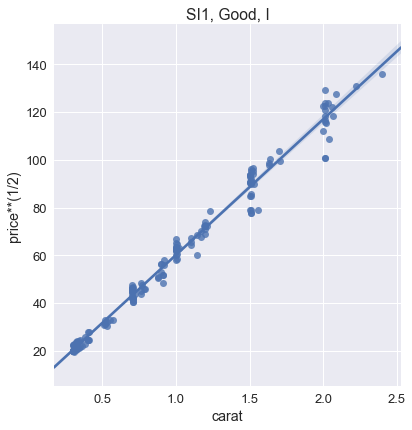

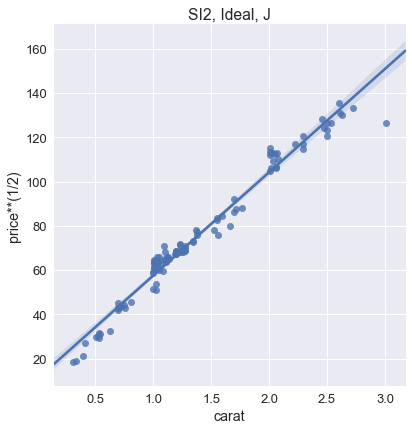

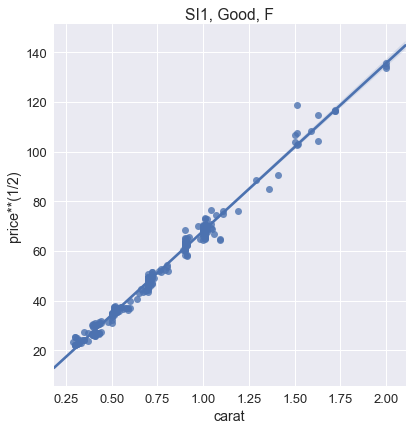

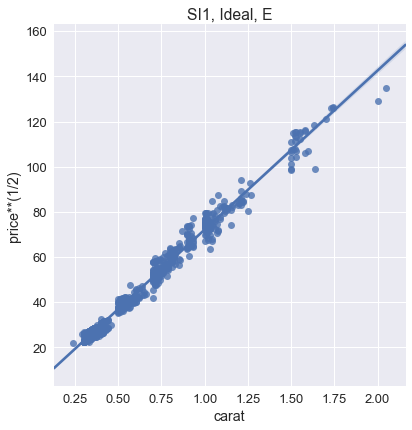

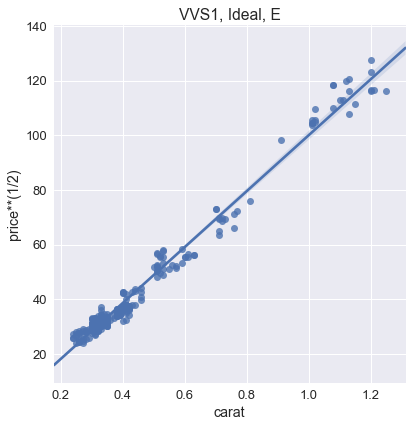

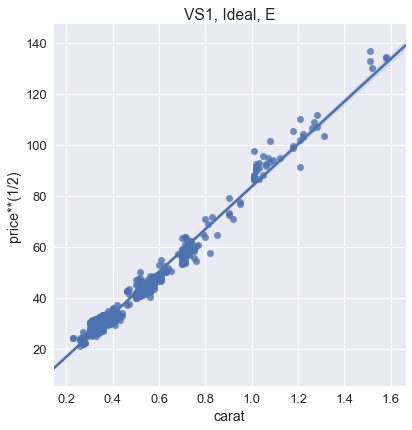

In [16]:
#Randomly choose some larger clarity cut and color diamond groups and plot them
for i in range(15):
    plt_random_category(lambda x : x**(1/2), True, 'price**(1/2)')

Not too bad. We end up with something linear up to maybe 1.75 carats. After that the fitted functions tend to over predict the square root of the price.

## Price prediction <a id="predict"></a>
We have seen that there is strong clustering of prices for each carat_group and choice of diamond category. It appears that a descision tree regressor based on all of the categorical data might work particularly well for larger diamonds. The other option that looks good from our analysis is to binarize the categorical variables and use linear regression to predict the square root of prices. This seems to under predict from around 1.75 carats in some groups. We will try each model and test for performance. Then we will try ensembling to see if we can improve performance. The ensembling methods tested include taking a weighted average, and choosing a model based on the size of the diamond.

(To be continued...)